In [1]:
#!pip install darts
import pandas as pd
from darts.models import XGBModel, LinearRegressionModel, RegressionModel
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.frequencies import Timestamp
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import darts
from scipy.stats import ttest_ind
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler,StandardScaler
from darts.models import XGBModel, ExponentialSmoothing, RegressionModel, LinearRegressionModel,LightGBMModel,RegressionEnsembleModel ,ARIMA, AutoARIMA
import holidays
import statsmodels.api as sm
from datetime import timedelta
from darts import TimeSeries
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
df = pd.read_csv("Data/assignment4.1a.csv",parse_dates = ["Date"],dayfirst = False)
df2= pd.read_csv("Data/assignment4.1b.csv",parse_dates = ["Date"],dayfirst = False)
df3 = pd.read_csv("Data/assignment4.1c.csv")
df_promo = pd.read_csv("Data/PromotionDates.csv",dayfirst=False,
                       parse_dates=["StartDate","EndDate"],dtype={"StartDate":"str",
                                                                  "EndDate":"str"})
df_promo.replace({"1/9/2015" : "9/1/2015",
                  "6/9/2015":"9/6/2015",
                  "20/11/2015":"11/20/2015",
                  "27/11/2015":"11/27/2015"},inplace=True)
df_promo.iloc[:,1:] = df_promo.iloc[:,1:].astype("str")

In [3]:
date_group = df.groupby("Date").SalesQuantity.sum()

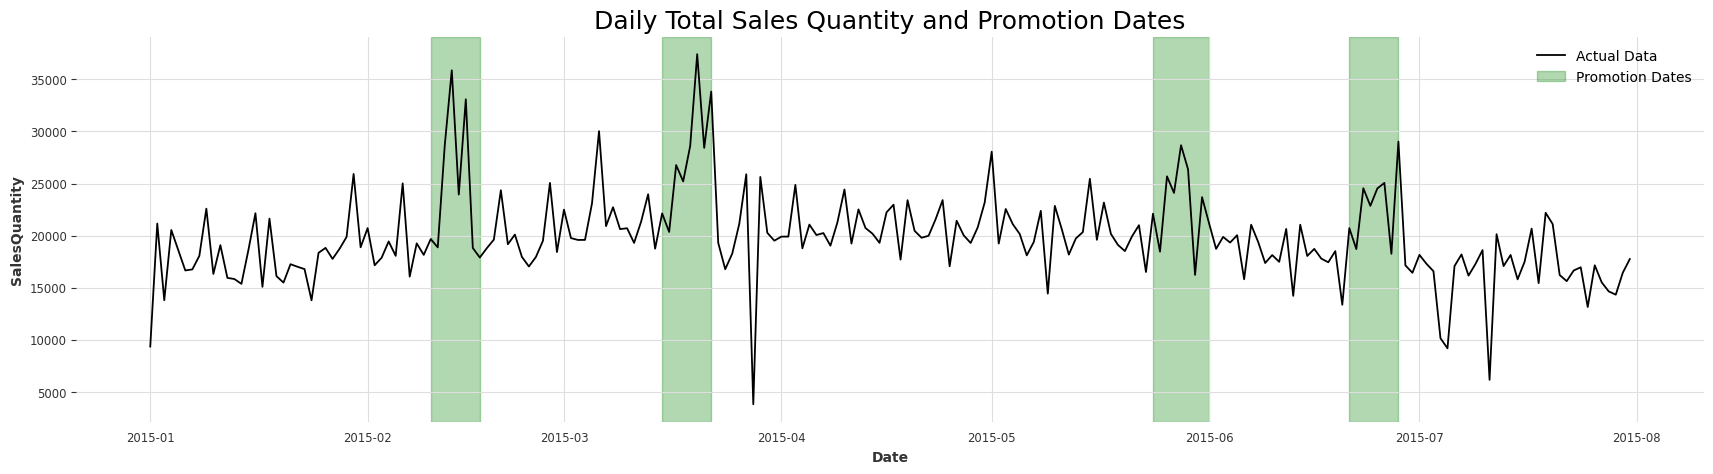

In [4]:
plt.figure(figsize=(21,5))
plt.title("Daily Total Sales Quantity and Promotion Dates",fontdict={"size":18})
sns.lineplot(date_group,label = "Actual Data")
for i in df_promo.Period.tolist()[0:4]:
  sd = pd.to_datetime(df_promo[df_promo.Period==i]["StartDate"].values[0])
  ed = pd.to_datetime(df_promo[df_promo.Period==i]["EndDate"].values[0])
  
  plt.axvspan(sd,
            ed,color = "green", alpha = 0.3,label = "Promotion Dates")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2])
plt.show()

In [5]:
tr_hol = holidays.country_holidays("TR")

promo_dates = []
for i in df_promo.Period.tolist():
    sd = pd.to_datetime(df_promo[df_promo.Period == i]["StartDate"].values[0])
    ed = pd.to_datetime(df_promo[df_promo.Period == i]["EndDate"].values[0])
    promo_dates.extend(pd.date_range(start = sd,end = ed))

ff_promo_dates = []
for i in df_promo.Period.tolist()[:4]:
    sd = pd.to_datetime(df_promo[df_promo.Period == i]["StartDate"].values[0])
    ed = pd.to_datetime(df_promo[df_promo.Period == i]["EndDate"].values[0])
    promo_dates.extend(pd.date_range(start = sd,end = ed))

first_weekend_after_promo = [x+timedelta(days=7) for x in promo_dates if x.dayofweek in [5,6]]

sd= df.Date.min()
ed= df.Date.max()

first_data_range = pd.date_range(start=sd,end=ed)
non_promo_dates = [x for x in first_data_range if x not in promo_dates]
non_promo_data = df[df.Date.isin(non_promo_dates)]
promo_data = df[~df.Date.isin(non_promo_dates)]
non_promo_data.Date.nunique(),promo_data.Date.nunique()


(179, 33)

In [6]:
merged = pd.merge(df,df3, how = "left", on = "ProductCode")
merged.head()

,Date,StoreCode,ProductCode,SalesQuantity,ProductGroup1,ProductGroup2
0,2015-01-01,8,9,-1,H,15
1,2015-01-01,131,9,1,H,15
2,2015-01-01,144,9,2,H,15
3,2015-01-01,203,9,2,H,15
4,2015-01-01,256,9,0,H,15


In [7]:
def label(data = non_promo_data,criterium= "StoreCode"):
  groups = non_promo_data.groupby(criterium)["SalesQuantity"].sum().reset_index()
  groups[[criterium,"SalesQuantity"]]
  low = groups.SalesQuantity.quantile(0.25)

  high = groups.SalesQuantity.quantile(0.75)
  groups[f"{criterium}_labels"] = pd.cut(groups["SalesQuantity"],bins = [-np.inf,low,high,np.inf],labels = ["Slow","Medium","Fast"])
  return groups[[criterium,f"{criterium}_labels"]]
store_groups = label()
product_groups = label(data=non_promo_data,criterium="ProductCode")

In [8]:
merged = pd.merge(left = merged, right = store_groups, on="StoreCode",how='left')
merged = pd.merge(left = merged, right = product_groups, on="ProductCode",how='left')
merged.head()

,Date,StoreCode,ProductCode,SalesQuantity,ProductGroup1,ProductGroup2,StoreCode_labels,ProductCode_labels
0,2015-01-01,8,9,-1,H,15,Medium,Medium
1,2015-01-01,131,9,1,H,15,Fast,Medium
2,2015-01-01,144,9,2,H,15,Slow,Medium
3,2015-01-01,203,9,2,H,15,Slow,Medium
4,2015-01-01,256,9,0,H,15,Fast,Medium


In [9]:
g1 = merged.groupby(["Date","ProductGroup1"])["SalesQuantity"].sum().reset_index()
g2 = merged.groupby(["Date","ProductGroup2"])["SalesQuantity"].sum().reset_index()
g3 = merged.groupby(["Date","StoreCode_labels"])["SalesQuantity"].sum().reset_index()
g4 = merged.groupby(["Date","ProductCode_labels"])["SalesQuantity"].sum().reset_index()

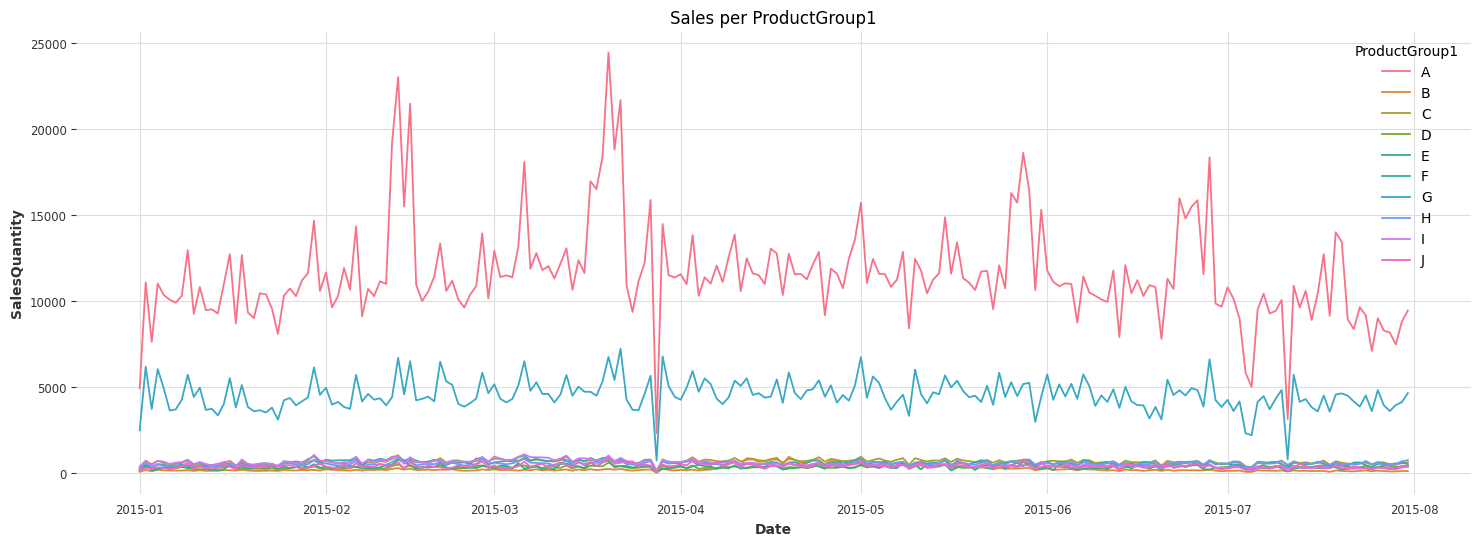

In [10]:
plt.figure(figsize=(18,6))
plt.title("Sales per ProductGroup1")
sns.lineplot(data = g1, x = "Date",y = "SalesQuantity", hue = "ProductGroup1" )

plt.show()

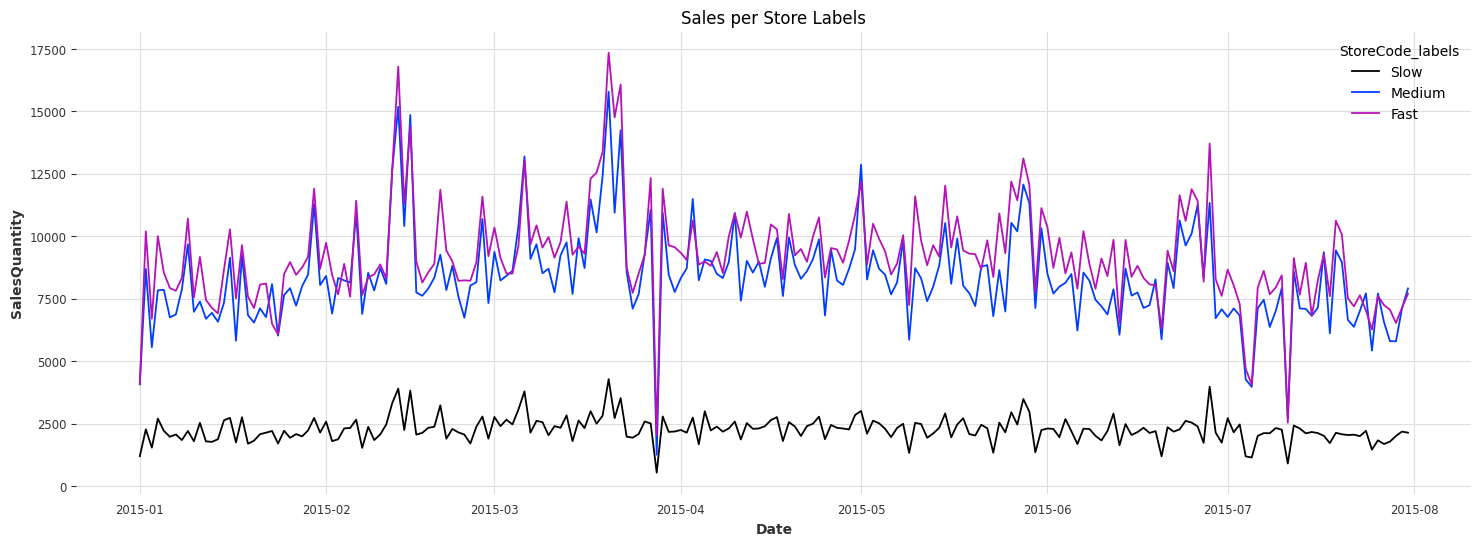

In [11]:
plt.figure(figsize=(18,6))
plt.title("Sales per Store Labels")
sns.lineplot(data = g3, x = "Date",y = "SalesQuantity", hue = "StoreCode_labels" )
plt.show()

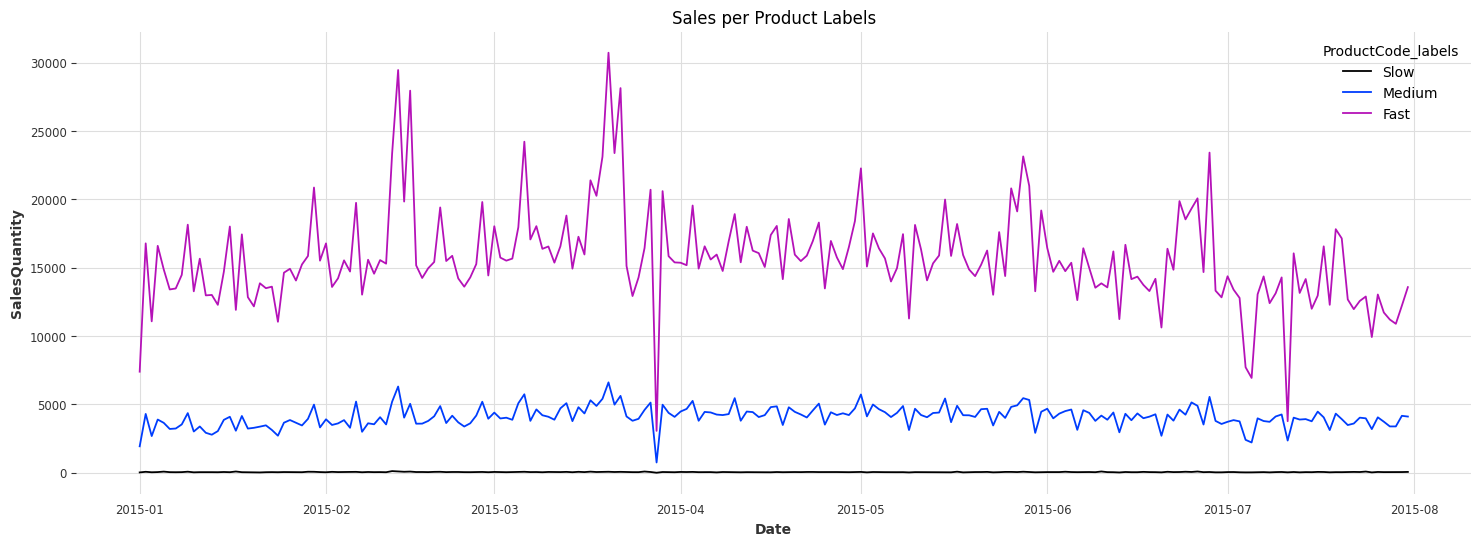

In [12]:
plt.figure(figsize=(18,6))
plt.title("Sales per Product Labels")
sns.lineplot(data = g4, x = "Date",y = "SalesQuantity", hue = "ProductCode_labels" )
plt.show()

In [13]:
sd = df.Date.min()
ed = df2.Date.max()

all_range = pd.date_range(sd,ed)
full_range = pd.DataFrame({"Date" :all_range})

In [14]:
def is_fwap(x):
  if x in first_weekend_after_promo:
    return 1
  else:
    return 0

def is_promodate(x):
  if x in promo_dates:
    return 1
  else:
    return 0

def is_holiday(x):
  if x in tr_hol:
    return 1
  else:
    return 0

def is_workday(x):
  if x in [5,6]:
    return 1
  else:
    return 0

In [15]:
def create_features(frame):
  frame["is_holiday"] = frame.Date.apply(lambda x:is_holiday(x))
  frame["week"] = frame.Date.dt.isocalendar().week
  frame["month"] = frame.Date.dt.month
  frame["day"] = frame.Date.dt.dayofweek
  frame["is_weekend"] = frame.day.apply(lambda x : is_workday(x))
  frame["is_promo_date"] = frame.Date.apply(lambda x : is_promodate(x))
  frame["is_fwap"] = frame.Date.apply(lambda x : is_fwap(x))
  return frame

g1 = create_features(g1)
g2 = create_features(g2)
full_range = create_features(full_range)
full_range = full_range.set_index("Date")


In [16]:
g1.head()


,Date,ProductGroup1,SalesQuantity,is_holiday,week,month,day,is_weekend,is_promo_date,is_fwap
0,2015-01-01,A,4929,1,1,1,3,0,0,0
1,2015-01-01,B,81,1,1,1,3,0,0,0
2,2015-01-01,C,378,1,1,1,3,0,0,0
3,2015-01-01,D,159,1,1,1,3,0,0,0
4,2015-01-01,E,227,1,1,1,3,0,0,0


In [17]:
def fill_dates(data):
  sd = df.Date.min()
  ed = df.Date.max()
  first_range = pd.date_range(sd,ed)
  first_range = pd.DataFrame({"Date" :first_range})
  data = data.reset_index()
  data = pd.merge(left = first_range,right = data, how="left",on="Date").fillna(0)
  data.columns = ["Date","SalesQuantity"]
  data = data.set_index("Date")
  return data


9 different models contribute to the final prediction by crossing 3 store and 3 product groups.
Mean absolute percentage error: 14.23 %


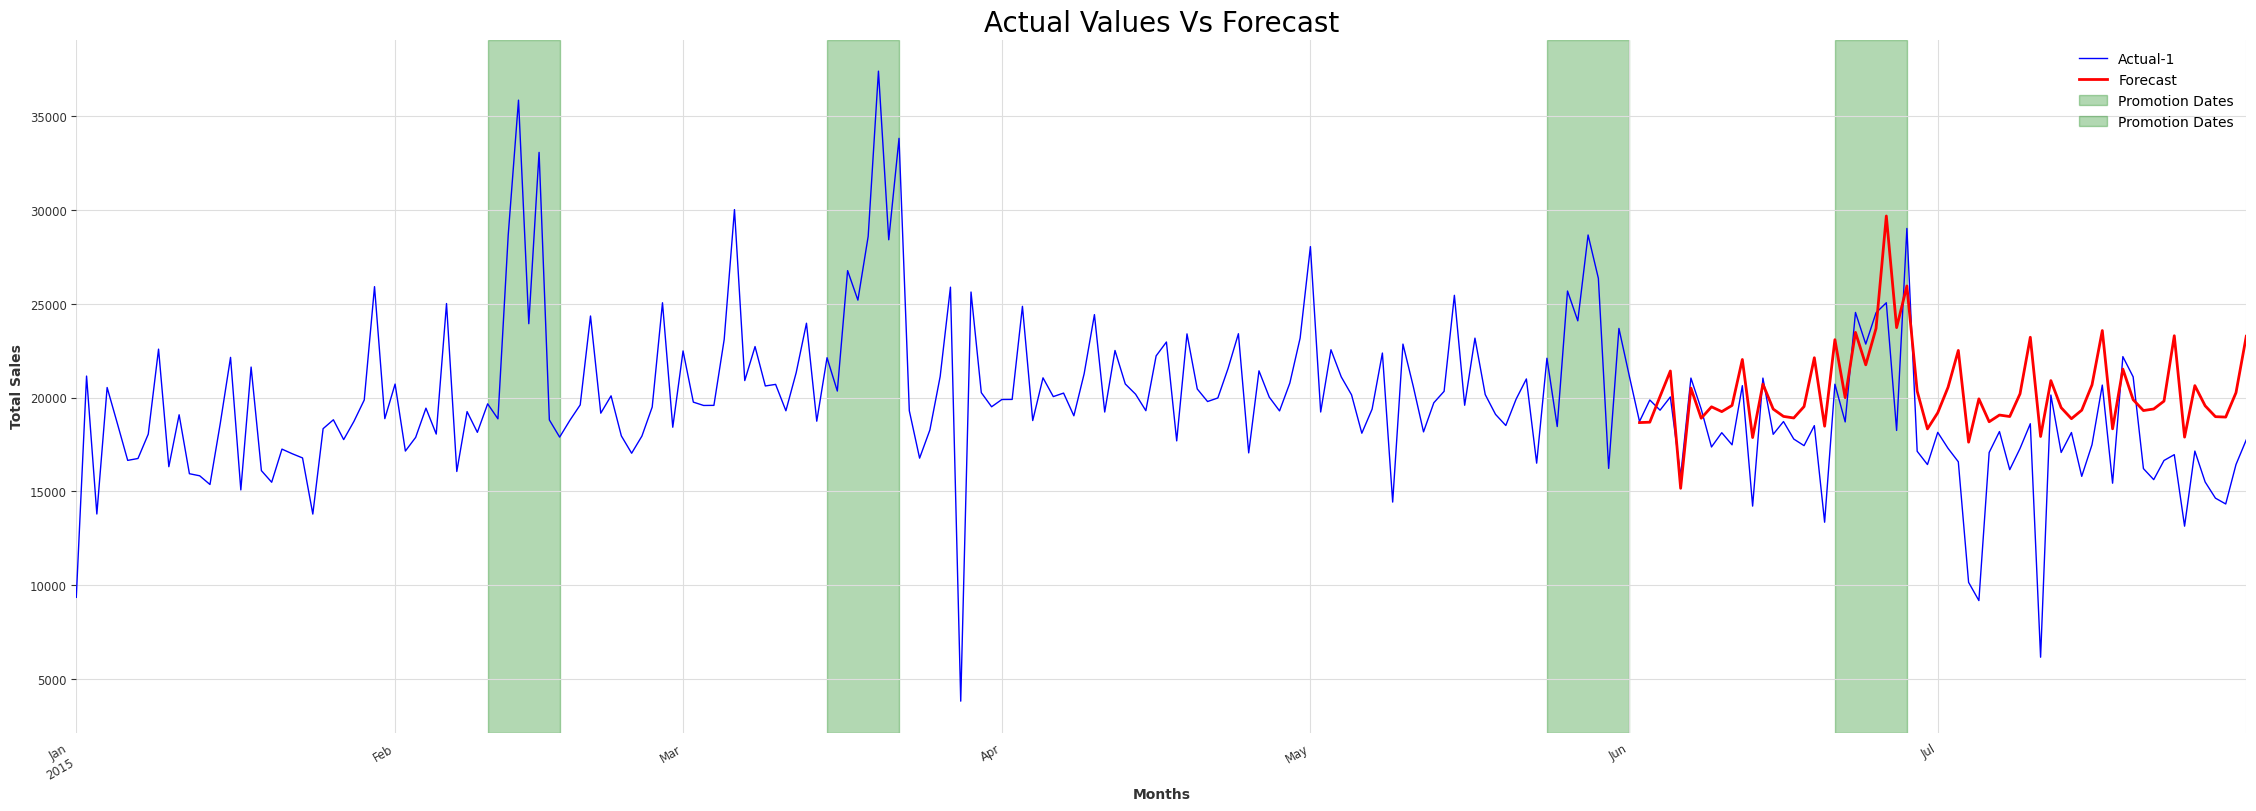

In [18]:
def make_predictions(split_from_previous = 40, predict_step_forward = 40,column_to_cross="ProductCode_labels"):
  ## MODELING
  preds = []
  total_models = 0
  store_labels = 0
  record = {}
  for l in merged.StoreCode_labels.unique():      # Go through all store groups ("Fast","Slow","Medium")
    store_specific = merged[merged.StoreCode_labels==l]
    sliced_data  = store_specific.groupby(["Date",column_to_cross])["SalesQuantity"].sum().reset_index()      # Filter only the data with the current store group name, e.g only Fast stores
    store_labels +=1
    product_labels = 0
    predictions_track = {}
    for i in sliced_data[column_to_cross].unique():                                                    # Loop through all product groups ("Fast", "Slow", "Medium")
      data_to_forecast = sliced_data[sliced_data[column_to_cross]==i].set_index("Date")
      data_to_forecast = fill_dates(data_to_forecast["SalesQuantity"])                                 # Fill the spaces in the daily time series index
      y = TimeSeries.from_series(data_to_forecast["SalesQuantity"], fill_missing_dates=True, fillna_value=0, freq="D")        # Create a darts time series object

      features = ["is_holiday",	"week",	"day","is_weekend",	"is_promo_date","is_fwap"]                 # Select the features names to use in the model
      features = TimeSeries.from_dataframe(full_range[features])                                       # Create another darts time series object for features
      split_date = Timestamp(2015,7,31) - timedelta(days=split_from_previous)                          # Define the spliting point
      train,_ = y.split_after(split_date)                                                            # Create train and validation data using the splitting point

      model = XGBModel(lags = [-1,-4,-5,-7], lags_future_covariates=[0])                           # Instantiate the model

      model.fit(train,                                                                                 # Fit the sales data and other features
                future_covariates=features
                )
      prediction = model.predict(n = predict_step_forward,                                             # Make recursive predictions for the current store-product pair
                                series= train,
                                future_covariates = features
                                )
      preds.append(prediction)                                                                         # Store the predictions for the current store-product pair
      total_models += 1
      product_labels += 1
      predictions_track[i] = prediction
    record[l] = predictions_track
  print(f"{total_models} different models contribute to the final prediction by crossing {store_labels} store and {product_labels} product groups.")
  total_preds = sum(preds)                                                                             # Sum all predictions made for each store-product pairs to get the total sales

  ## VISUALIZATION
  plt.figure(figsize=(28,9))
  date_gg = df.groupby("Date")["SalesQuantity"].sum()
  date_gg1 = df2.groupby("Date")["SalesQuantity"].sum()
  date_gg.plot(label='Actual-1',color = 'blue',lw=1)
  if split_date + timedelta(days=predict_step_forward) <= Timestamp(2015,7,31):
    mape = mean_absolute_percentage_error(total_preds.pd_series().values, date_gg.values[-split_from_previous:]) * 100
    pass
  else:
    forecast_steps = (split_date + timedelta(days=predict_step_forward) - Timestamp(2015,7,31)).days
    date_gg1[:abs(forecast_steps)].plot(label='Actual-2',color = 'green', lw =1 )
    mape = mean_absolute_percentage_error(total_preds.pd_series().values, date_gg1.values[:forecast_steps]) * 100
  print("Mean absolute percentage error: {:.4g} %".format(mape))
  total_preds.plot(label='Forecast',color = 'red',lw = 2)
  for i in df_promo.Period.tolist():
    sd = pd.to_datetime(df_promo[df_promo.Period==i]["StartDate"].values[0])
    ed = pd.to_datetime(df_promo[df_promo.Period==i]["EndDate"].values[0])
    plt.axvspan(sd,
              ed,color = "green", alpha = 0.3,label = "Promotion Dates")
  plt.title("Actual Values Vs Forecast",fontdict={"fontsize":20})
  handles, labels = plt.gca().get_legend_handles_labels()
  plt.legend(handles[:4], labels[:4])
  plt.xlabel('Months')
  plt.ylabel('Total Sales')
  plt.show()
  return record,total_preds


_,_ = make_predictions(60,60,"ProductCode_labels")

9 different models contribute to the final prediction by crossing 3 store and 3 product groups.
Mean absolute percentage error: 8.046 %


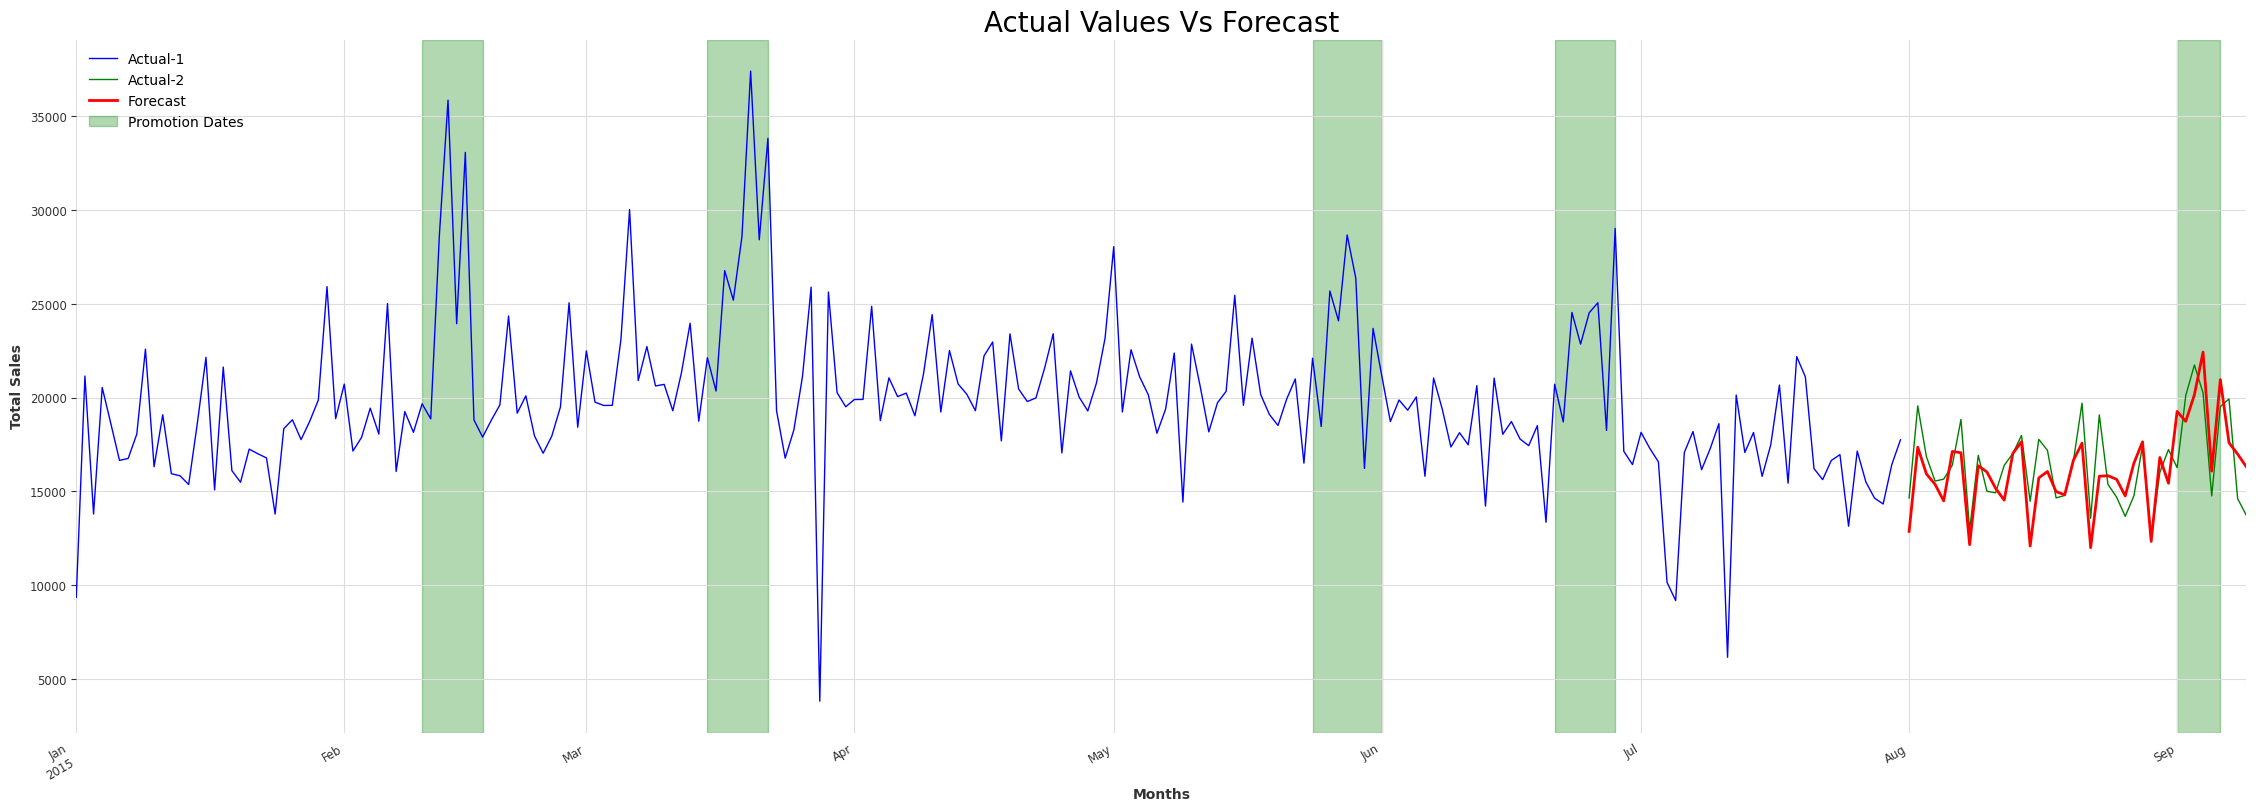

In [19]:
record,predictions = make_predictions(0,40,"ProductCode_labels")

In [20]:
tags = ["Fast","Medium","Slow"]
df_record = {}
for s in tags:
  if len(record[s]) == 3:
    tags1 = tags
  else:
    tags1 = np.arange(1,31)
  for p in tags1:
    serie = record[s][p].pd_series()
    ps = pd.to_datetime("2015-09-01")
    pe = pd.to_datetime("2015-09-06")
    bps = ps - timedelta(days=7)
    bpe = pe - timedelta(days=7)
    before = serie[(serie.index >= bps)&(serie.index <= bpe)].mean()
    during = serie[(serie.index >= ps)&(serie.index <= pe)].mean()
    df_record[f"{s} store x {p} product"] = [before,during]

promotion_forecast = pd.DataFrame(data = df_record, index = ["Before", "During"]).T
promotion_forecast["Promo_effect"] = ((promotion_forecast.During / promotion_forecast.Before) - 1) * 100
promotion_forecast.sort_values("Promo_effect",ascending=False,inplace=True)
promotion_forecast.style.highlight_max(color = 'green')

,Before,During,Promo_effect
Fast store x Fast product,5773.683594,8362.573242,44.839478
Medium store x Slow product,25.106565,31.725767,26.364422
Slow store x Slow product,7.191667,8.869360,23.328293
Slow store x Fast product,1380.594238,1662.380371,20.410501
Medium store x Medium product,1534.118652,1816.035156,18.376446
Medium store x Fast product,4765.367676,5407.257324,13.469887
Slow store x Medium product,513.900696,573.436707,11.585116
Fast store x Medium product,1599.580688,1726.469604,7.932639
Fast store x Slow product,19.678225,21.161581,7.538056


### Bonus Question - Return Rate Analysis

The legal time window to return an item in Turkey is 14 days. This means that the items bought during promotions can be returned within 14 days. I will consider this time window and calculate return rates for each day. Then, I will conduct an independent student's t-test to check if the difference is significant.

In [21]:
dates_for_promo_return = sorted(list(set([date + timedelta(days=14) for date in promo_dates] + promo_dates)))
dates_regular_returns = [date for date in all_range if date not in dates_for_promo_return]

def calculate_return_rates(date_list):
    all_df = pd.concat([df,df2],axis = 0)
    returned = all_df[all_df.Date.isin(date_list) & (all_df.SalesQuantity < 0)][["Date","SalesQuantity"]]
    returned = returned.groupby("Date").sum()
    not_returned = all_df[all_df.Date.isin(date_list) & (all_df.SalesQuantity > 0)][["Date","SalesQuantity"]]
    not_returned = not_returned.groupby("Date").sum()
    base_df = pd.DataFrame({"Date":date_list})

    return_merged = pd.merge(base_df, returned, how = "left", on = "Date", suffixes = ("_returned", "_not_returned"))
    return_merged = pd.merge(return_merged, not_returned, how = "left", on = "Date", suffixes = ("_returned", "_not_returned"))

    return_merged["return_rate"] = (abs(return_merged.SalesQuantity_returned) / (abs(return_merged.SalesQuantity_returned) + return_merged.SalesQuantity_not_returned)) * 100
    return return_merged

In [22]:
return_rates_promotion =  calculate_return_rates(dates_for_promo_return)
return_rates_promotion.dropna(inplace=True)
return_rates_non_promotion =  calculate_return_rates(dates_regular_returns)
return_rates_non_promotion.dropna(inplace=True)

In [23]:
return_rates_non_promotion.head(3)

,Date,SalesQuantity_returned,SalesQuantity_not_returned,return_rate
0,2015-01-01,-31.0,9386,0.329192
1,2015-01-02,-133.0,21289,0.620857
2,2015-01-03,-49.0,13848,0.352594


In [26]:
return_rates_promotion.head(3)

,Date,SalesQuantity_returned,SalesQuantity_not_returned,return_rate
0,2015-02-10,-124.0,19799,0.622396
1,2015-02-11,-61.0,18936,0.321103
2,2015-02-12,-112.0,28791,0.387503


In [27]:
result = ttest_ind(return_rates_non_promotion["return_rate"],return_rates_promotion["return_rate"])
p_value = round(result[1],3)
p_value < 0.05
print(f"p-value is {p_value}, which is bigger than our critical value 0.05 \nWe can conclude that the return rates are not significantly different when promotion days and regular days are compared.")

p-value is 0.066, which is bigger than our critical value 0.05 
We can conclude that the return rates are not significantly different when promotion days and regular days are compared.
